In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math 

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import holidays
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

from sklearn.metrics import r2_score, mean_absolute_error

sns.set()

random_state = 123_456
np.random.seed(random_state)

In [2]:
holiday_list = list()

for date, name in holidays.AU(prov='NSW', years=[2016,2017,2018,2019,2020]).items():
    holiday_list.append(dict(ds=date,holiday=name))
    
df_holidays = pd.DataFrame(holiday_list)
# df_holidays

In [3]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [4]:
features = ['price','price_t_plus_1']

In [5]:
df = df[features].copy()
df

price  price_t_plus_1
2017-01-01   1417            1436
2017-01-02   1436            1409
2017-01-03   1409            1542
2017-01-04   1542            1582
2017-01-05   1582            1529
...           ...             ...
2019-12-27   1608            1589
2019-12-28   1589            1579
2019-12-29   1579            1602
2019-12-30   1602            1609
2019-12-31   1609            1609

[1095 rows x 2 columns]

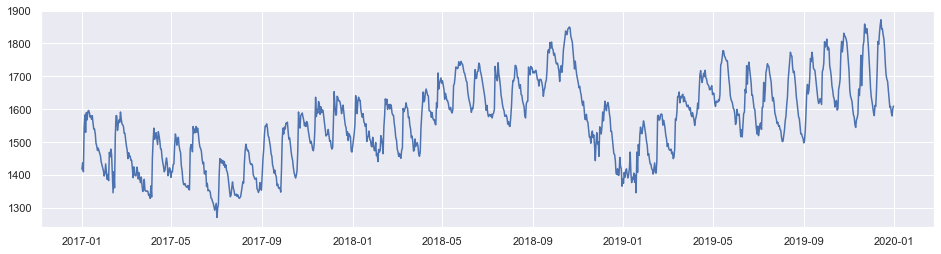

In [6]:
plt.figure(figsize=(16, 4))
plt.plot(df.index, df.price)
plt.show()

In [7]:
start_date = '2019-08-01'

In [8]:
df_to_predict = df[df.index >= start_date]

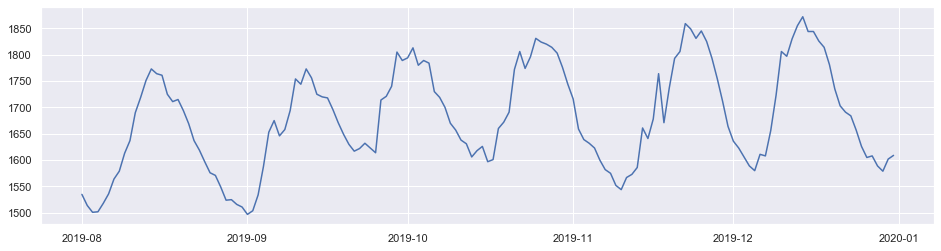

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(df_to_predict.index, df_to_predict.price)
plt.show()

In [10]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [11]:
counter = 0
my_list = list()

for index, values in df_to_predict.iterrows():
    counter += 1
    
    df_p = df[['price']][df.index < index].copy()
    df_p['ds'] = df_p.index
    df_p.rename(columns={'price': 'y'}, inplace=True)
    df_p.reset_index(inplace=True, drop=True)

    fbp = Prophet(daily_seasonality=False, holidays=df_holidays, changepoint_range=0.7)
    _ = fbp.fit(df_p)
    df_f = fbp.make_future_dataframe(periods=1, include_history=False)
    df_fc = fbp.predict(df_f)
    
    print(index)
    my_list.append(dict(date=index, y_test=values.price_t_plus_1, y_hat=int(round(df_fc.yhat.values[0]))))
#     if counter > 1: break

2019-08-01 00:00:00
2019-08-02 00:00:00
2019-08-03 00:00:00
2019-08-04 00:00:00
2019-08-05 00:00:00
2019-08-06 00:00:00
2019-08-07 00:00:00
2019-08-08 00:00:00
2019-08-09 00:00:00
2019-08-10 00:00:00
2019-08-11 00:00:00
2019-08-12 00:00:00
2019-08-13 00:00:00
2019-08-14 00:00:00
2019-08-15 00:00:00
2019-08-16 00:00:00
2019-08-17 00:00:00
2019-08-18 00:00:00
2019-08-19 00:00:00
2019-08-20 00:00:00
2019-08-21 00:00:00
2019-08-22 00:00:00
2019-08-23 00:00:00
2019-08-24 00:00:00
2019-08-25 00:00:00
2019-08-26 00:00:00
2019-08-27 00:00:00
2019-08-28 00:00:00
2019-08-29 00:00:00
2019-08-30 00:00:00
2019-08-31 00:00:00
2019-09-01 00:00:00
2019-09-02 00:00:00
2019-09-03 00:00:00
2019-09-04 00:00:00
2019-09-05 00:00:00
2019-09-06 00:00:00
2019-09-07 00:00:00
2019-09-08 00:00:00
2019-09-09 00:00:00
2019-09-10 00:00:00
2019-09-11 00:00:00
2019-09-12 00:00:00
2019-09-13 00:00:00
2019-09-14 00:00:00
2019-09-15 00:00:00
2019-09-16 00:00:00
2019-09-17 00:00:00
2019-09-18 00:00:00
2019-09-19 00:00:00


In [12]:
df_hat = pd.DataFrame(my_list)
df_hat.set_index('date', inplace=True)

In [13]:
error_tolerance_percentage = 2.5

In [14]:
get_relative_accuracy(df_hat.y_test.values, df_hat.y_hat.values, error_tolerance_percentage)

0.20915032679738563

In [15]:
r2_score(df_hat.y_test, df_hat.y_hat)

-0.02349244792065419

In [16]:
mean_absolute_error(df_hat.y_test, df_hat.y_hat)

83.63398692810458

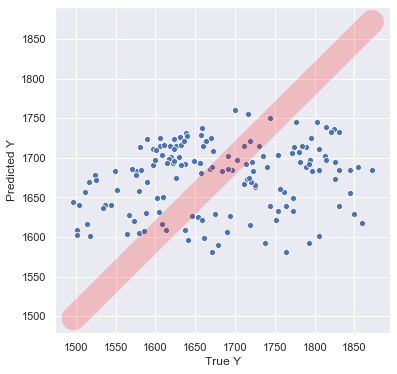

In [17]:
line_x_y = [math.floor(min(df_hat.y_test.min(),df_hat.y_hat.min())), 
            math.ceil(max(df_hat.y_test.max(),df_hat.y_hat.max()))]
_ = plt.figure(figsize = (6, 6))
_ = plt.plot(line_x_y, line_x_y, linewidth=24, alpha=0.2, color='red')
_ = sns.scatterplot(df_hat.y_test, df_hat.y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()